In [1]:
import pandas as pd
import numpy as np; np.random.seed(0)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import sys

feature_files = ['SP500', 'Gold', 'WTI', 'US10Y', 'DAX', 'FTSE', 'Nikkei', 
                 'Shanghai', 'USD_HKD']  
target_file = 'DXY'

In order to predict US Dollar Index, **I choose the following features: S&P 500 Index(SP500), Gold Price (Gold), Crude Oil WTI(WTI), US 10-Year Bond Yield(US10Y), the German Stock Index(DAX), the UK Stock Index(FTSE), the Japan Stock Index(Nikkei), the China Stock Index(Shanghai) and the price of USD to HKD currency(USD_HKD).** I use the historical data from 01/01/2005 to 08/02/2019. Each indicator contains closing , open, high, and low prices. 

In [2]:
for n, f in enumerate([target_file]+feature_files):
    df_tmp = pd.read_csv(f+'.csv', sep = ',', thousands = ',', header = 0,
                         index_col = 0)
    df_tmp = df_tmp.drop('Change %', axis = 1)
    try:
        df_tmp = df_tmp.drop('Vol.', axis = 1)
    except:
        pass
    df_tmp.index = pd.to_datetime(df_tmp.index)
    df_tmp.columns = ['Price-'+f, 'Open-'+f, 'high-'+f, 'low-'+f]    
    if n == 0:
        df = df_tmp
    else:
        df = df.join(df_tmp)

By using for loop, we can combine all dataset into one. Since every feature file has columns of price, open, high, and low, I add the name of each feature file at the end.

In [3]:
df = df.interpolate(method='linear')
df = df.iloc[::-1]

There are some missing value in the dataset, so I use interpolation to replace the missing values. Replacing missing value is not necessary in Random Forest model.

In [4]:
def timeseries_to_array(df_v, history_steps = 5):
    for n in range(df_v.shape[0]-history_steps):  
        step_features = df_v.iloc[n:n+history_steps,:].values.flatten().reshape((1,-1))
        step_target = df_v.iloc[n+history_steps, 0]
        if n == 0:
            feature_array = step_features
            target_array = [step_target]
        else:
            feature_array = np.concatenate((feature_array, step_features), axis = 0)
            target_array.append(step_target)
    return feature_array, np.array(target_array)



This part is to set up the function of autoregression. It uses the observations from previous 5 days as input to predict the value for next day. It reads the original observation, flattens all observations, and concatenates them together. 

### Prediction of US Dollar price with Random Forest 

In [5]:
print('df.shape', df.shape)
x_train, y_train = timeseries_to_array(df.iloc[:-50,:], 5)
x_test, y_test = timeseries_to_array(df.iloc[-50:,:], 5)
print('x_train.shape', x_train.shape)
print('y_train.shape', y_train.shape)
print('x_test.shape', x_test.shape)
print('y_test.shape', y_test.shape)

df.shape (3781, 40)
x_train.shape (3726, 200)
y_train.shape (3726,)
x_test.shape (45, 200)
y_test.shape (45,)


The target is to predict the US Dollar Index. The first column is our target, and the rest columns are features.The original data set has 40 columns and 3781 rows. Base on the concept of autoregression, I uses observations from previous 5 steps as input to predict the value at the next step. So in the traing set and test set, there are total of 200 features (40 x 5 days). I use the data to predict the latest 50 days of US Dollar Index. 

In [6]:
model = RandomForestRegressor(n_estimators = 100, max_depth = 10, 
                              max_features = 1.0, verbose = 0)
model.fit(x_train, y_train)

y_pred = model.predict(x_test)
print('mse root:', round(np.sqrt(np.mean(np.square(y_test-y_pred))),3))
print('r2_score:', r2_score(y_test, y_pred))

mse root: 0.337
r2_score: 0.6918892773215379


R-squared is a statistical measure of how close the data are to the fitted regression line. The R-Squared is 0.71, which shows the fitting is not bad.

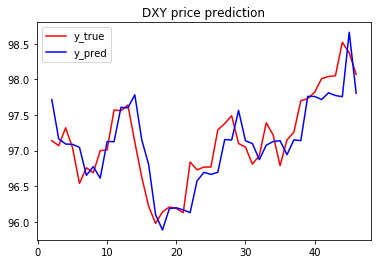

In [7]:
plt.figure(0)
plt.plot(list(range(2,len(y_pred)+2)), y_test,'r', 
         list(range(2,len(y_pred)+2)), y_pred, 'b')
#plt.xticks(ticks = np.arange(2,27,2))
plt.legend(['y_true', 'y_pred'])
plt.title(target_file+' price prediction')
plt.savefig('predict.png')



**Overfitting???**This graph shows the trend of prediction and the real data. The performance is really good. 

### Prediction of US Dollar price by Year

In [8]:
df.index=pd.to_datetime(df.index)
df['year']=df.index.year


for v in range(2005,2020):
    df_v=df.loc[df.loc[:,'year']==v, :]
    df_v=df_v.drop(columns=['year'])
    feature_v, target_v =  timeseries_to_array(df_v, history_steps = 5)
    print('df_%s:' %v, 'shape:', feature_v.shape, target_v.shape)
    model = RandomForestRegressor(n_estimators = 100, max_depth = 5, 
                                  max_features = 0.7, verbose = 0)
    model.fit(feature_v, target_v)
    y_pred = model.predict(feature_v)
    print('r2_score:', round(r2_score(target_v, y_pred),3))
    print('mse root:', round(np.sqrt(np.mean(np.square(target_v-y_pred))),3))

df_2005: shape: (250, 200) (250,)
r2_score: 0.993
mse root: 0.252
df_2006: shape: (247, 200) (247,)
r2_score: 0.991
mse root: 0.207
df_2007: shape: (248, 200) (248,)
r2_score: 0.998
mse root: 0.142
df_2008: shape: (254, 200) (254,)
r2_score: 0.996
mse root: 0.32
df_2009: shape: (256, 200) (256,)
r2_score: 0.995
mse root: 0.301
df_2010: shape: (255, 200) (255,)
r2_score: 0.991
mse root: 0.266
df_2011: shape: (255, 200) (255,)
r2_score: 0.982
mse root: 0.258
df_2012: shape: (256, 200) (256,)
r2_score: 0.983
mse root: 0.18
df_2013: shape: (256, 200) (256,)
r2_score: 0.981
mse root: 0.178
df_2014: shape: (256, 200) (256,)
r2_score: 0.998
mse root: 0.138
df_2015: shape: (256, 200) (256,)
r2_score: 0.965
mse root: 0.344
df_2016: shape: (256, 200) (256,)
r2_score: 0.989
mse root: 0.251
df_2017: shape: (256, 200) (256,)
r2_score: 0.996
mse root: 0.209
df_2018: shape: (256, 200) (256,)
r2_score: 0.994
mse root: 0.2
df_2019: shape: (149, 200) (149,)
r2_score: 0.963
mse root: 0.136


According to the result, most years fit really well. 

### Analysis of Feature Importancy by Year

In [9]:
df.index=pd.to_datetime(df.index)
df['year']=df.index.year
print(df.shape)    

(3781, 41)


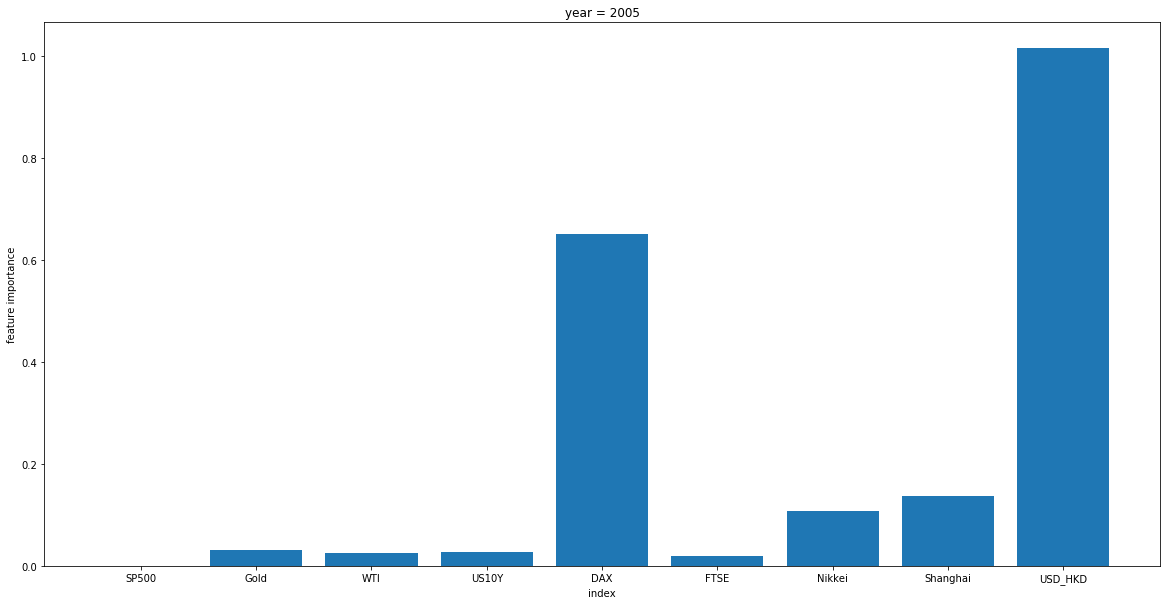

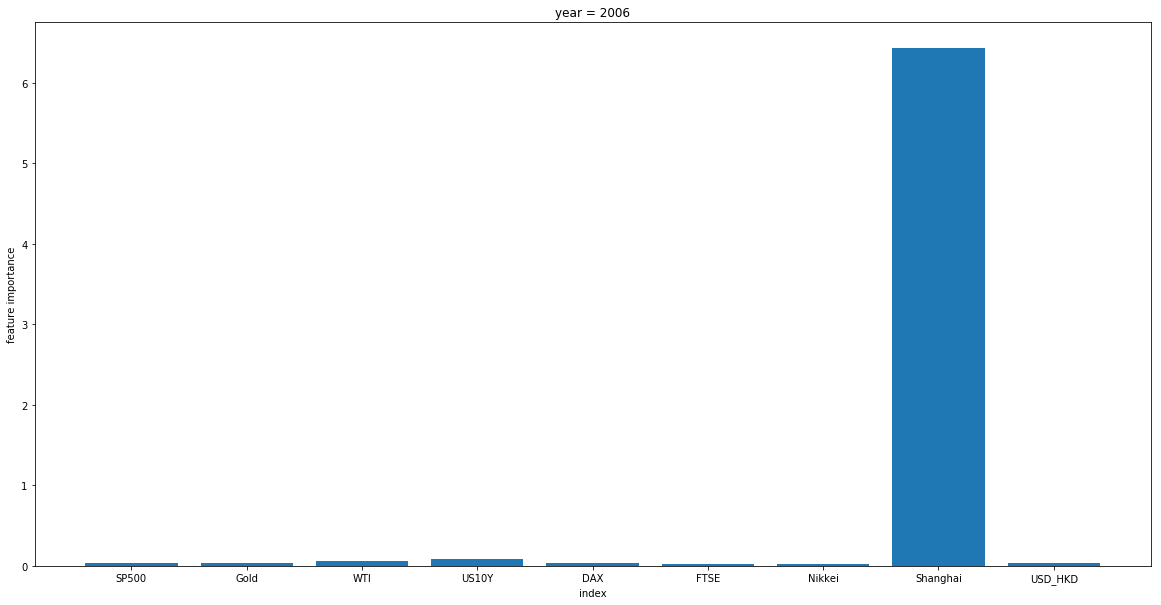

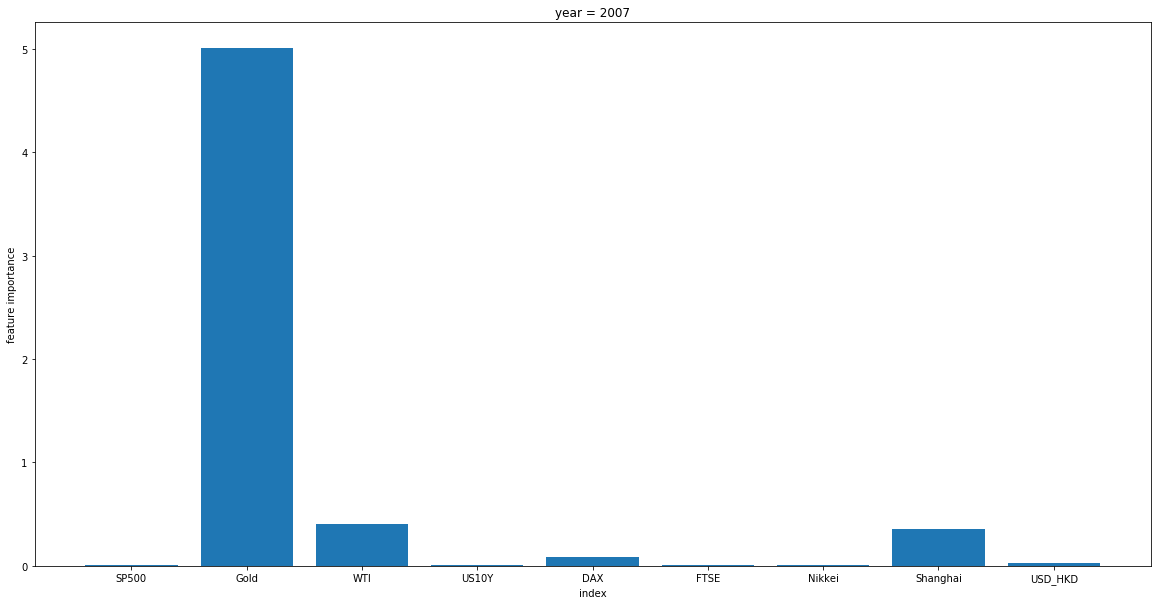

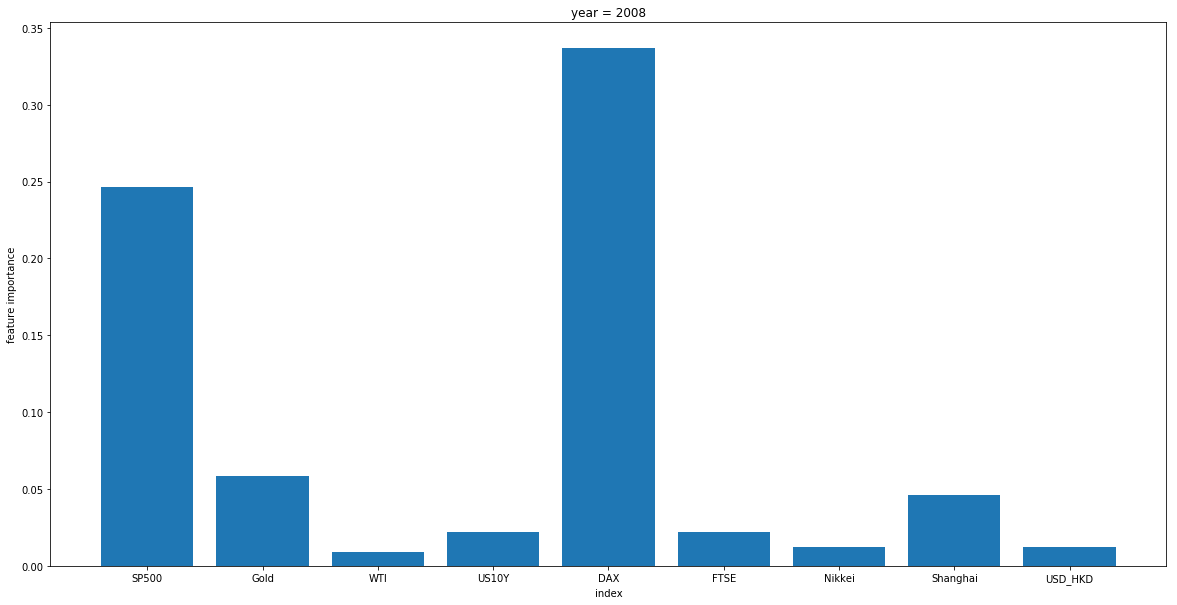

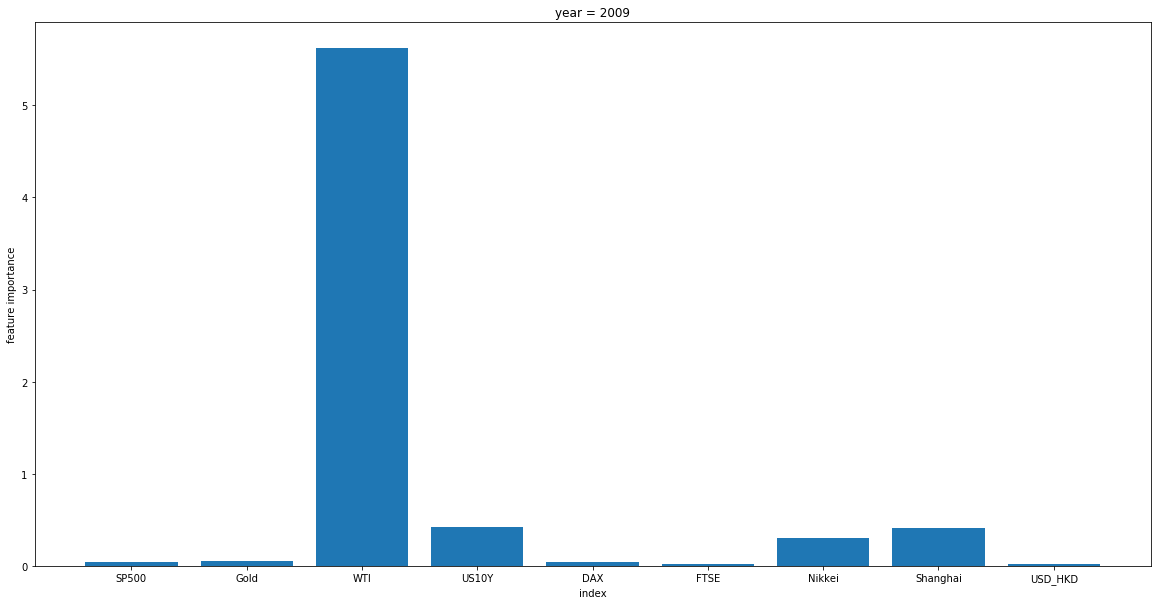

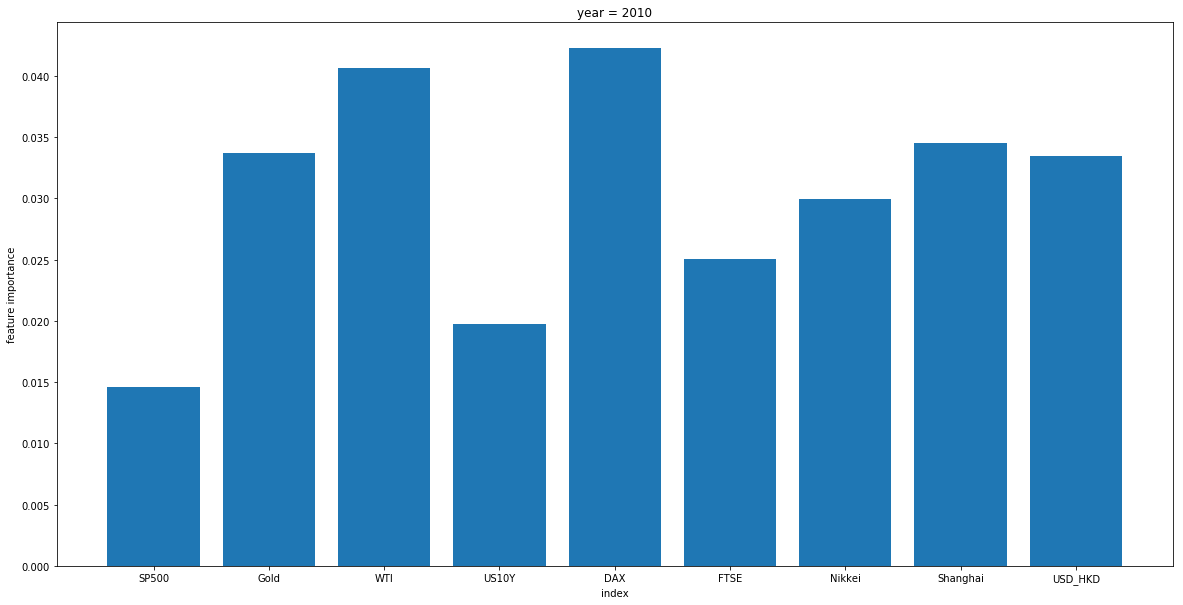

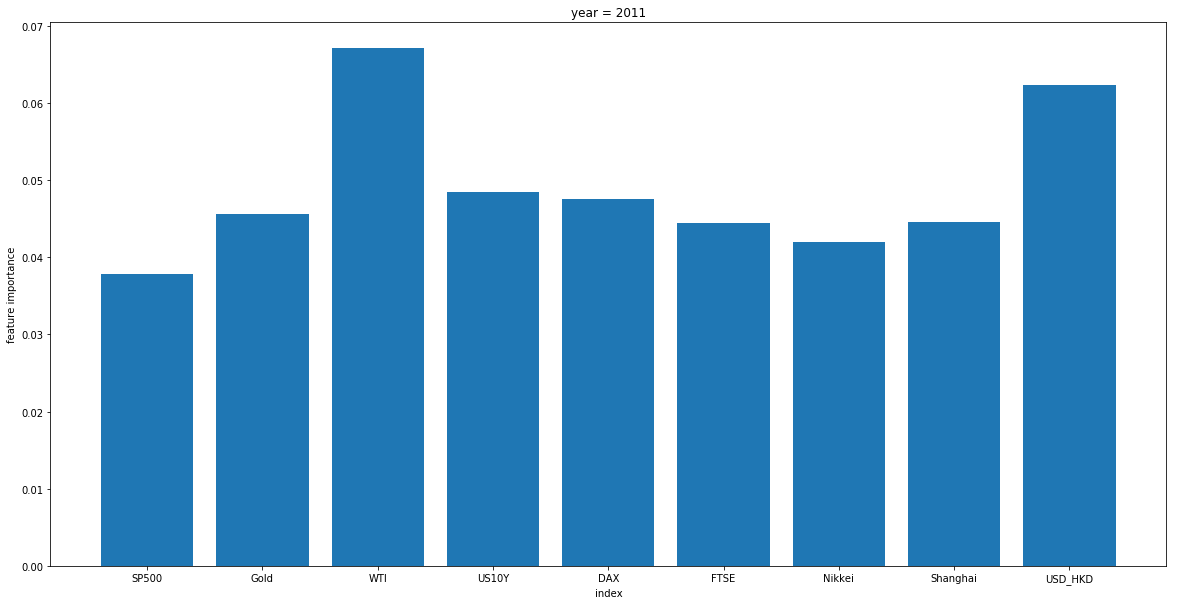

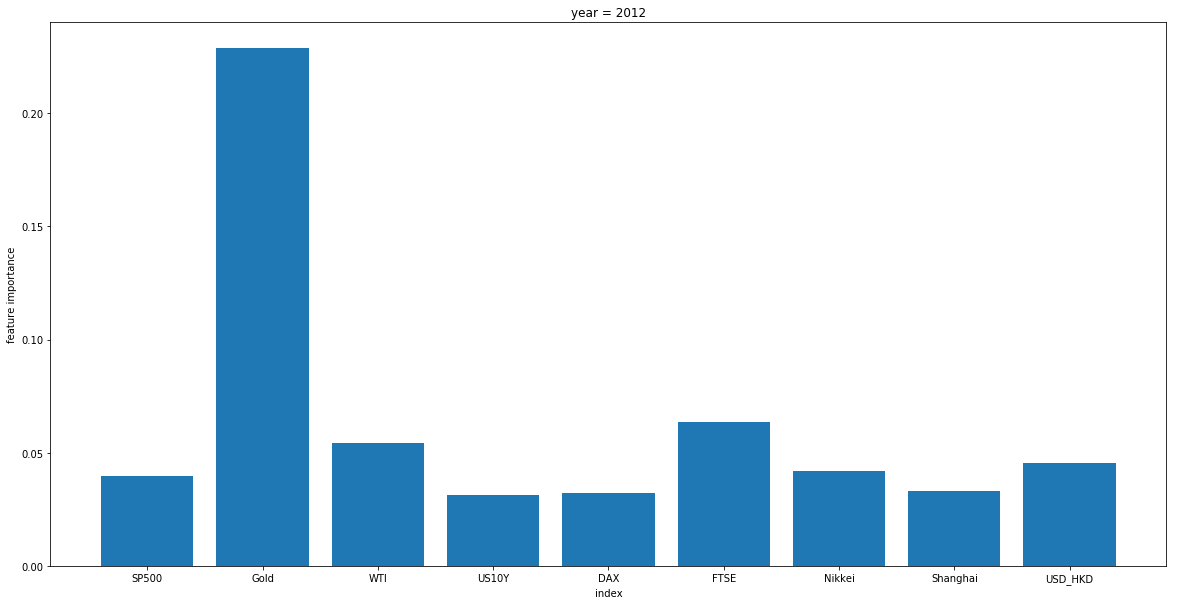

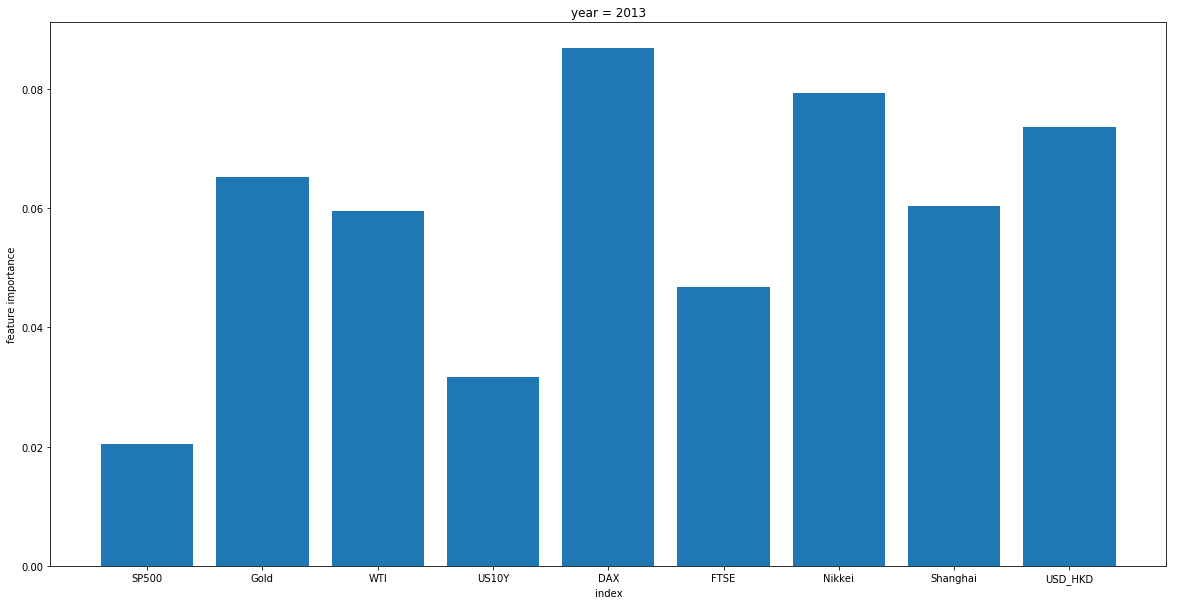

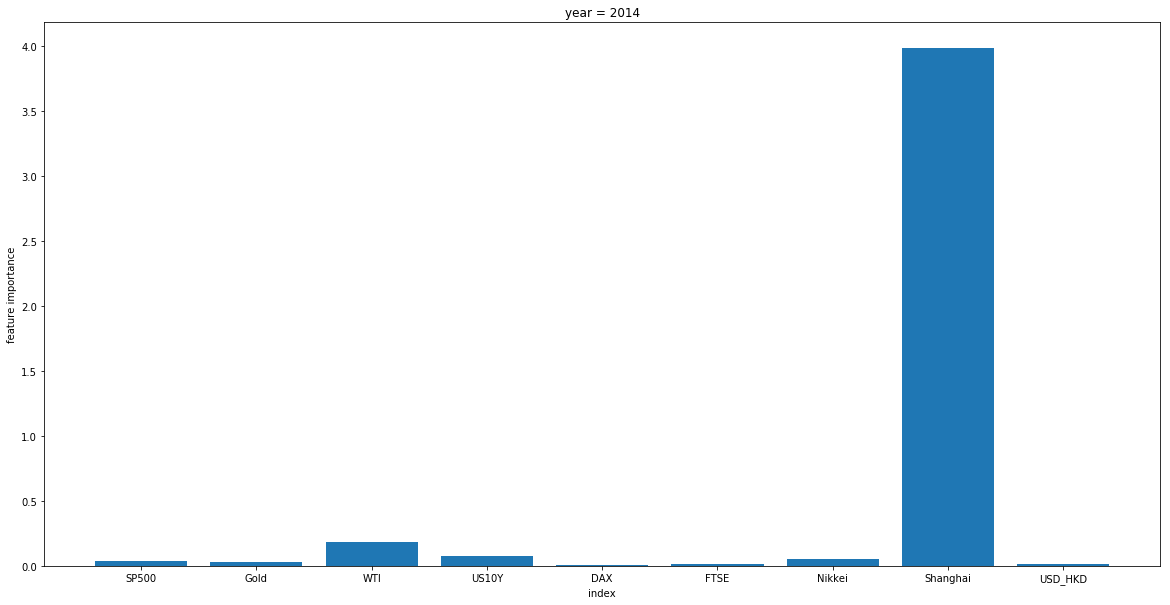

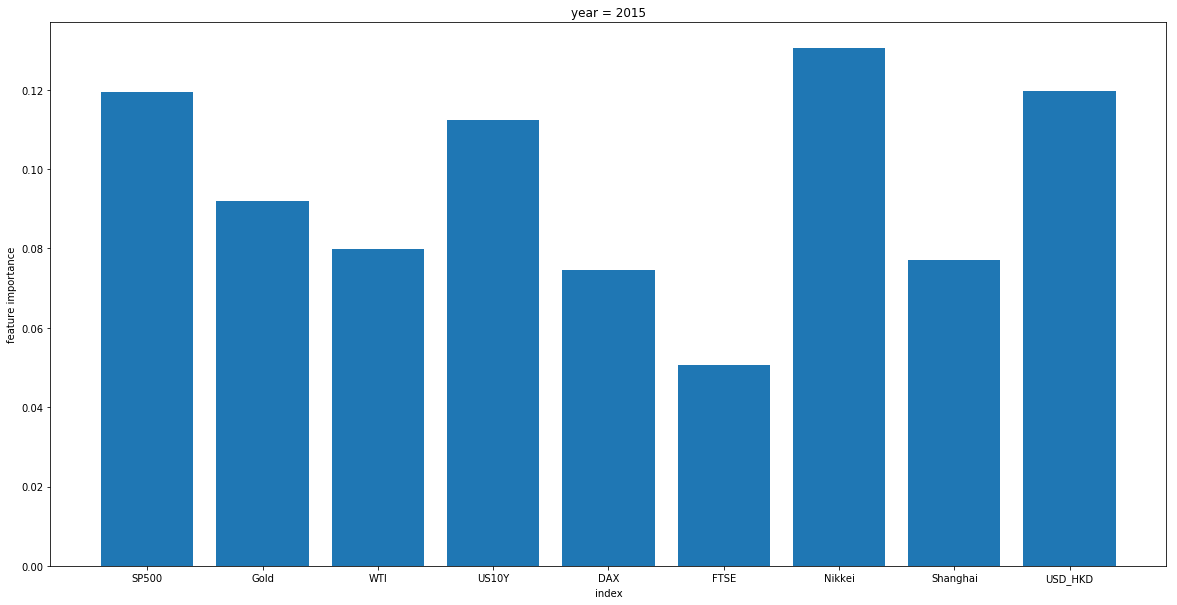

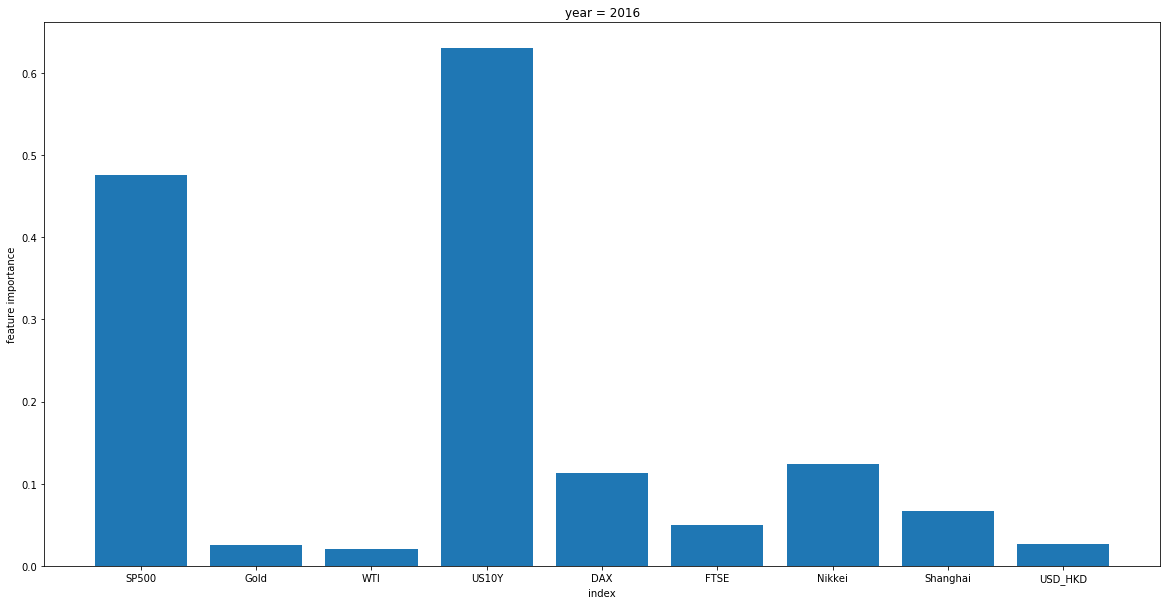

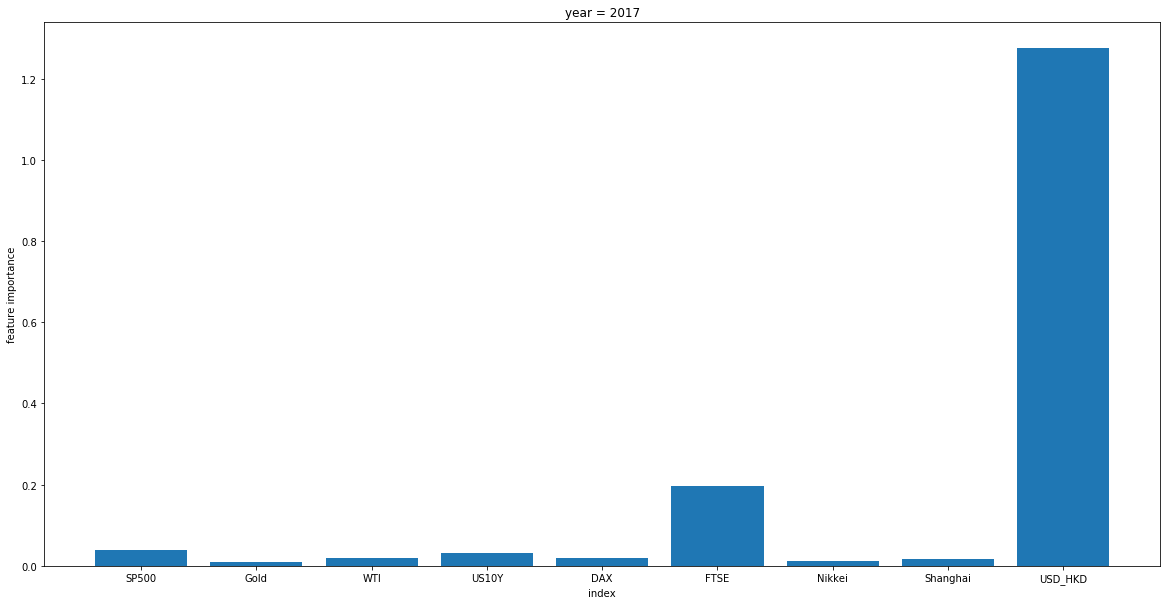

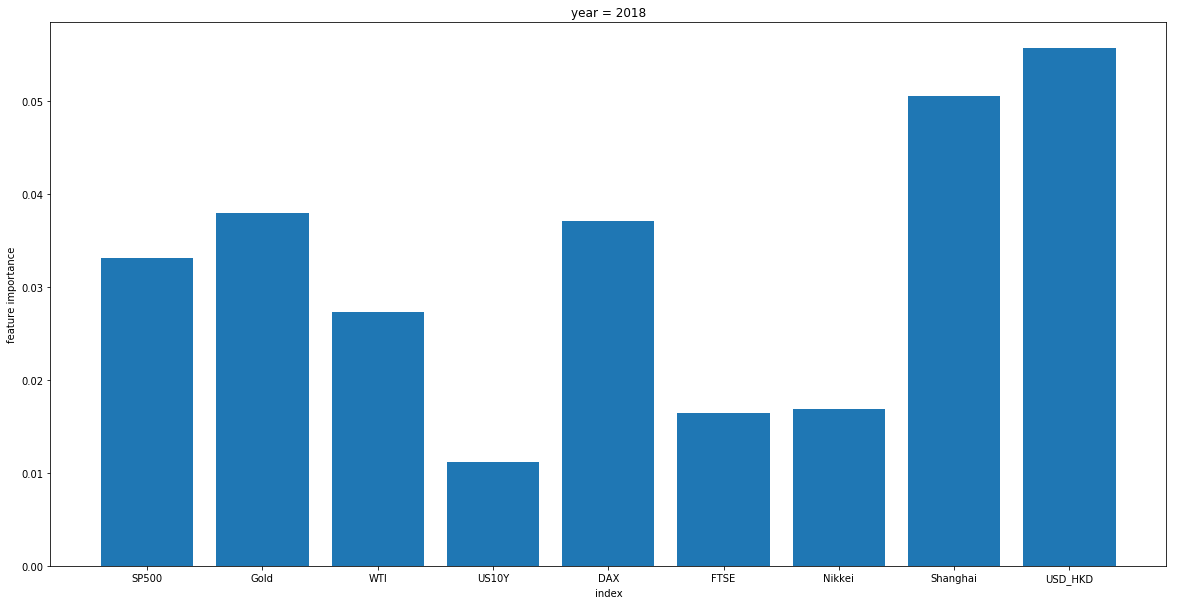

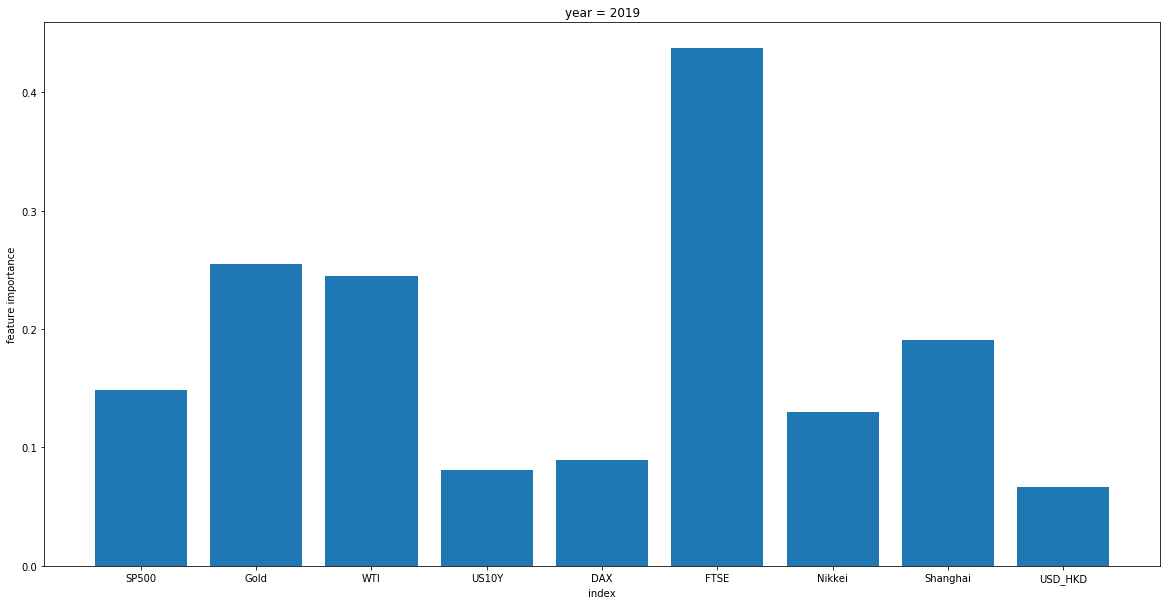

In [10]:
for v in range(2005,2020):
    df_v=df.loc[df.loc[:,'year']==v, :]
    df_v=df_v.drop(columns=['year'])
    feature_v, target_v =  timeseries_to_array(df_v, history_steps = 5)
    model = RandomForestRegressor(n_estimators = 100, max_depth = 10, 
                                  max_features = 0.7, oob_score = True, verbose = 0)
    model.fit(feature_v, target_v)
    y_pred = model.predict(feature_v)
       
    #feature importance
    FIP = np.zeros((len(feature_files+[target_file])*4*5,))
    for n in range(10):
        FIP = FIP + model.feature_importances_
    FIP_10 = FIP / 10
        
    n_index=len(feature_files+[target_file])
    history_steps = 5
    FIP_by_index = np.zeros((n_index,))
    for n in range(n_index):
        for m in range(history_steps):
            FIP_by_index[n] = FIP_by_index[n]+ np.sum(
                FIP[ m*n_index*4 + (n)*4: m*n_index*4 + (n+1)*4])
  
    plt.figure(figsize=(20, 10))
    plt.bar(feature_files, FIP_by_index[1:]
           )
    plt.title('year = '+str(v))
    plt.xlabel('index')
    plt.ylabel('feature importance')
plt.show()


From these 15 graphs, the importancy of features changes in different year. For example, the German stock index,DAX, is the most important features in 2005. But, in 2014, the China stock index, Shanghai, becomes the most important feature. There is no features that has strong effect in 2019. So this analysis gives us a big picture about how feature importancies changing with years and help us to make investment strategy.